## Median_search

In [1]:
## Returns all possible permutations of length l, with characters A,C,G,T
##
## Example: 
## Input:  length=2
## Output: ["AA", "AC", "AT", "AG", "CA", "CC", "CT", "CG", "TA", "TC", "TT", "TG", "GA", "GC", "GT", "GG"]
function allPermutations(length)
    
    if length==1
        return ["A","C","T","G"]
    end
    
    suffix_permutations=allPermutations(length-1)
    
    ans=[]
    for c in "ACTG"
       for suffix in suffix_permutations
            push!(ans,c*suffix)
        end
    end
    
    return ans
end

## Given two strings of equal length, returns the no. of mismatches characters
##
## Example: 
## Input: string1="ATG", string2="ACG"
## Output: 1
function getMismatches(string1,string2)
    mismatches = 0
    for (c1,c2) in zip(string1,string2)
        if c1!=c2
            mismatches+=1
        end
    end

    return mismatches
end

## dna - all dna strings in an array
## l   - length of motif
##
## Returns the best motif, score for the best motif, and the start positions for the motif
function medianString(dna,l)
    
    t = length(dna)    ##  No. of dna sequences
    n = length(dna[1]) ##  length of each dna sequence
   
    scores = [l for i in 1:t]
    start =  [1 for i in 1:t]
    
    best_score = l*t 
    best_positions = []
    
    all_permutations = allPermutations(l)
    median_string = all_permutations[1]
    
    for permutation in all_permutations

        scores = [l for i in 1:t]
        start =  [1 for i in 1:t]

        for j in 1:t   
            dna_seq = dna[j]
            for start_position in 1:n-l+1

                mismatches = getMismatches(permutation,dna_seq[start_position:start_position+l-1])

                if scores[j]>mismatches
                    scores[j] = mismatches
                    start[j] = start_position
                end
            end
        end

        curr_score = sum(scores)
        if curr_score<best_score
             best_score = curr_score
             best_positions = deepcopy(start)
             median_string = permutation
        end
    end
    
    return median_string,best_score,best_positions
end

medianString (generic function with 1 method)

In [2]:
 median_string,best_score,best_positions = medianString(["TGGCGTCG","GGCGGGCG","TCTTCGCC","CCCGCTCC"],3)

("CGC", 2, [2, 1, 5, 3])

## Branch and Bound

In [3]:
#Pkg.add("TimerOutputs")
using Random
using Gadfly

In [4]:
function create_neighbours(initial_string,infrequents = Set())
    """
    Input_params:  
    initial_string(str): An initial string, which is concatenated with 'A','C','T','G' to  create a bigger motif.
    infrequents(Set): A set of infrequent motifs, that is used for pruning prefixes which are of low frequency. 
    
    Returns
    next_neighbours(str): A list of potential motifs, by extending the initial string. 
    
    Example:
    
    create_neighbours("AC",infrequents) :
        if "AC" or any of its prefixes are not in the infrequent set:
            returns  ["ACA","ACG","ACC","ACT"]
        else:
            returns []
    """
    next_neighbours  =  []  
    flag = 1
    for i in range(1,length(initial_string))
        if initial_string[1:i] in infrequents
            flag = 0
            break
        end
    end
    if flag==0
       return [] 
    end
    for next_chr in ["A","C","T","G"]
        next_initial_string = initial_string*next_chr
        push!(next_neighbours,next_initial_string)
    end
    return next_neighbours
end

create_neighbours (generic function with 2 methods)

In [60]:
function branch_and_bound_helper(input_str,starting_mofits,goal,l,answers,infrequents = Set())
    """
    Input_params:  
    Input_str (list) : The input DNA sequence from which motifs are to be discovered
    starting_motifs(list): The list of starting motifs that is used to create longer neighbours 
    goal(int): The hamming distance to be considered for the no of mismatches allowed
    answers(list): The list of all possible motifs that is found by the program execution
    infrequents(Set): A set of infrequent motifs, that is used for pruning prefixes which are of low frequency. 
    
    """
    next_adjacent_neighbours = []
    for next_neighbours in starting_mofits
        v = create_neighbours(next_neighbours)
        if length(v)!=0
            push!(next_adjacent_neighbours,v)
        end
    end
    next_adjacent_neighbours = [y for item in next_adjacent_neighbours for y in item]
    new_motifs = []
    for potential_motif in next_adjacent_neighbours
        if is_motif_valid(input_str,potential_motif,goal)==false
            push!(infrequents,potential_motif)
        elseif  length(potential_motif)==l
            push!(answers,potential_motif)
            return 
        else
            push!(new_motifs,potential_motif)       
        end
    end
                
    if length(next_adjacent_neighbours)>=1 && length(next_adjacent_neighbours[1]) < l
        branch_and_bound_helper(input_str,new_motifs, goal, l, answers,infrequents)
    end
                
    return
end

                
function validate_by_hamming_distance(string, motif, goal )
    string_motifs = get_all_substrings(string, length(motif))
    for curr_motif in string_motifs
        error =  calculate_hamming_distance(curr_motif, motif)
        if error <= goal
            return true
        end
    end
    return false
end


function is_motif_valid(input_strings, motif, goal=1 )
    for string in input_strings
        if validate_by_hamming_distance(string, motif, goal) == false
            return false
        end
    end
    return true
end

            
function get_all_substrings(string, l)
    substrings = []
    for start in 1:length(string)-l+1
        push!(substrings, string[start:start+l-1])
    end
    return substrings
end

            
function calculate_hamming_distance(string, motif)
    error = 0
    for i in 1:length(motif)
        if string[i] != motif[i]
            error += 1
        end
    end
    return error
end


calculate_hamming_distance (generic function with 1 method)

In [6]:
function branch_and_bound(input_str,hamming_distance,motif_desired_length)
   """ 
   Input params:
   input_str(list) : The input DNA sequence from which motifs are to be calculated.
   hamming_distance(int): The hamming distance allowed between the concensus string and the different motifs. 
   motif_desired_length(int): The size of motifs that is supposed to be calculated. 
    
   Returns:
   answers(list): The list of possible answers found for the particular configuration(hamming_distance,motif_desired_length)
    
   """
   starting_motifs = create_neighbours("")
   answers = []
   branch_and_bound_helper(input_str,starting_motifs,hamming_distance,motif_desired_length,answers)
   return answers
    
end

branch_and_bound (generic function with 1 method)

## Creating DNA sequences

In [7]:
function create_artificial_sequence_with_motifs(n,l,motif_length,no_of_motifs,motifs,seed)
    """
    input_params:
        n(int) The no of dna sequences to be generated
        l(int) The length of each dna sequence
        motif_length(int) The length of the motif to be implanted
        no_of_motif(int) The no of motifs to be implanted in each dna
        motifs(list): The list of motifs to be implanted in each dna sequence
    
    Returns:
        r(list): The n*l dna sequences, having artificially implanted motifs in them. 
    
    """
    results = []
    arr = ['A','C','T','G']
    r = []
    Random.seed!(seed)
    for i in 1:n
        results = []
        for k in 1:l-motif_length*no_of_motifs
            idx = rand(1:4) 
            push!(results,arr[idx])
        end
        results = join(results)
        points = Set()
        while length(points)!=no_of_motifs
            idx = rand(1:length(results))
            push!(points,idx)
        end
        sorted_coor = []
        for elem in points
            push!(sorted_coor,elem)
        end
        intial_points = sort(sorted_coor)
        final_string = []
        past = 1
        temp = []
        shuffle!(motifs)
        for i in 1:no_of_motifs
            starts = intial_points[i]
            if past!=starts
                push!(temp,results[past:starts-1])
            end
            push!(temp,motifs[i])
            past = starts
        end
        if past<=length(results)
            push!(temp,results[past:length(results)])
        end
        resulting_string = join(temp)
        push!(r,resulting_string)
    end
    return r
 
end


function create_motif(n,l,seed)
    arr = ['A','C','T','G']
    Random.seed!(seed)
    motifs = []
    for i in 1:n
        temp = []
        for k in 1:l
            idx = rand(1:4) 
            push!(temp,arr[idx])
        end
        push!(motifs,join(temp))
    end
    return motifs  
end


function create_artificial_sequence(N,L,no_of_motifs,length_of_motifs,seed)
     motifs = create_motif(no_of_motifs,length_of_motifs,seed)
     sequence = create_artificial_sequence_with_motifs(N,L,length_of_motifs,no_of_motifs,motifs,seed)
     return motifs,sequence
end

#input_strings = create_artificial_sequence_with_motifs(10,100,5,4,["ACAAG","ACGGC","AACCA","AAGGG"])
# implanted_motifs,sequences = create_artificial_sequence(10,100,5,4)
# print(implanted_motifs,"\n")
# print(sequences,"\n")

create_artificial_sequence (generic function with 1 method)

┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = create_neighbours(::String, ::Set{Any}) at In[4]:20
└ @ Main .\In[4]:20


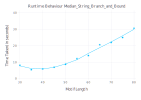

In [8]:
x,y = [],[]
for i in 30:5:70
    implanted_motifs,sequences = create_artificial_sequence(10,1000,1,i,i)
    t = @elapsed branch_and_bound(sequences,0,i)
    push!(x,i)
    push!(y,t)
end

Gadfly.plot(x=x,y=y,
Guide.xlabel("Motif Length"),
Guide.ylabel("Time Taken(in seconds)"),
Guide.title("Runtime Behaviour Median_String_Branch_and_Bound"),Geom.smooth,Geom.point)

┌ Warning: color("red") is deprecated, use colorant"red" or parse(Colorant, "red")
│   caller = top-level scope at In[9]:10
└ @ Core In[9]:10
┌ Warning: color("green") is deprecated, use colorant"green" or parse(Colorant, "green")
│   caller = top-level scope at In[9]:10
└ @ Core In[9]:10


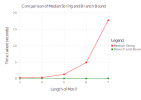

In [9]:
l,t1,t2 = [],[],[]
for ml in 3:7
    implanted_motifs,sequences = create_artificial_sequence(10,100,1,ml,77)
    t = @elapsed medianString(sequences,ml)
    push!(t1,t)
    t = @elapsed branch_and_bound(sequences,0,ml)
    push!(t2,t)
    push!(l,ml)
end

Gadfly.plot(layer(x=l,y=t1,Geom.line,Geom.point,Theme(default_color=color("red"))),
            layer(x=l,y=t2,Geom.line,Geom.point,Theme(default_color=color("green"))),
            Guide.xlabel("Length of Motif"),Guide.ylabel("Time taken(seconds)"),
            Guide.title("Comparison of Median String and Branch Bound"),
            Guide.manual_color_key("Legend", ["Median String", "Branch and Bound"], ["red", "green"]))

## Genetic Algorithm

In [46]:
function calculate_minimum_hamming_distance(input_strings, motif, string, input_motif_length)
    string_motifs = get_nth_substrings(input_strings, input_motif_length, string)
    error = input_motif_length
    for substring in string_motifs
        substring_error = calculate_hamming_distance(substring, motif)
        if substring_error < error
            error = substring_error
        end
    end
    return error
end

function calculate_fitness_score(input_strings, motif, input_motif_length)
    fitness_score = 0
    # valid = True
    for string in input_strings
        string_score = calculate_minimum_hamming_distance(input_strings, motif, string, input_motif_length)
        fitness_score = fitness_score + string_score
    end
    return (input_motif_length * length(input_strings)) - fitness_score
end

function mutate(motif, motif_characters, all_created_motifs)
    new_motif = generate_adjecent_motif(motif, motif_characters, all_created_motifs)
    if handled_previously(new_motif, all_created_motifs)
        return mutate(motif, motif_characters, all_created_motifs)
    end
    return new_motif
end

function reproduce(mom, dad, input_motif_length)
    random_index = rand([i for i in 1:input_motif_length-1])
    if (random_index - input_motif_length) < 0
        idx = input_motif_length + (random_index - input_motif_length) + 1
    else
        idx = (random_index - input_motif_length)
    end
    son = string(mom[1:random_index], dad[idx:end])
    daughter = string(dad[1:random_index], mom[idx:end])
#     son = mom[1:random_index] + dad[idx:end]
#     daughter = dad[1:random_index] + mom[idx:end]
    return (son, daughter)
end

function handled_previously(motif, all_created_motifs)
    return motif in all_created_motifs
end

function generate_initial_population(size, all_created_motifs, input_motif_length, motif_characters)
    population = []
    for i in 1:size
        motif = generate_random_potential_motif(input_motif_length, motif_characters)
        push!(population, motif)
        push!(all_created_motifs, motif)
    end
    return (collect(Set(population)), collect(Set(all_created_motifs)))
end

function get_random_from_population(input_strings, population, partner, input_motif_length)
    random_index = rand([i for i in 1:length(population)])
    motif = population[random_index]
    if ((!isempty(partner)) && (partner == motif))
        return get_random_from_population(input_strings, population, partner, input_motif_length)
    else
        return motif, get_fitness_score_percentage(input_strings, motif, input_motif_length)
    end
end

function get_fitness_score_percentage(input_strings, motif, input_motif_length)
    return calculate_fitness_score(input_strings, motif, input_motif_length) / (input_motif_length * length(input_strings))
end

get_fitness_score_percentage (generic function with 1 method)

In [47]:
function generate_random_potential_motif(input_motif_length, motif_characters)
    potential_motif = ""
    for i in 1:input_motif_length
        potential_motif *= rand(motif_characters)
    end
    return potential_motif
end

function generate_adjecent_motif(motif, motif_characters, all_created_motifs)
    this_motif_characters = split(motif, "")
    random_index = rand([i for i in 1:length(motif)])
    random_char = rand(motif_characters)
    while motif[random_index] == random_char
        random_char = rand(motif_characters)
    end
    this_motif_characters[random_index] = random_char
    generated_motif = join(this_motif_characters)
    if generated_motif in all_created_motifs
        return generate_adjecent_motif(motif, motif_characters, all_created_motifs)
    end
    return generated_motif
end


function get_nth_substrings(input_strings, len, str)
    substrings = []
    for limit in 1:length(input_strings[1]) - len
        push!(substrings, str[limit:limit + len])
    end
    return substrings
end

function calculate_hamming_distance(substring, motif)
    error = 0
    for i in 1:length(motif)
        if substring[i] != motif[i]
            error += 1
        end
    end
    return error
end

function is_motif_valid(input_strings, motif, goal=input_hamming_distance, length=input_motif_length)
    valid = true
    for string in input_strings
        if validate_by_hamming_distance(input_strings, string, motif, goal, length) == false
            valid = false
        end
    end
    return valid
end

function validate_by_hamming_distance(input_strings, string, motif, goal, len)
    motif_len = length(motif)
    string_motifs = get_nth_substrings(input_strings, motif_len, string)
    valid = false
    for smotif in string_motifs
        if valid != true
            error = 0
            for i in 1:motif_len
                if smotif[i] != motif[i]
                    error += 1
                end
            end
            if error <= goal
                valid = true
                break
            end
        end
    end
    return valid
end

validate_by_hamming_distance (generic function with 2 methods)

In [72]:
function genetic_algorithm(input_strings, size, input_motif_length, all_created_motifs, motif_characters, input_hamming_distance, depth, verbose=false)
#     ga_time = time()
    answer = []
    answer_score = []
    max_score = []
    population_averages = []
    most_close_to_answer = ""
    most_close_to_answer_score = 0
    (population, all_created_motifs) = generate_initial_population(size, all_created_motifs, input_motif_length, motif_characters)
    while depth > 0
        new_population = []
        if(length(population) < size)
            for i in 1:size - length(population)
                push!(population, generate_random_potential_motif(input_motif_length, motif_characters))
            end
        end
        for i in 1:length(population)
            (random_motif_dad, dad_fitness_score) = get_random_from_population(input_strings, population, [], input_motif_length)
            (best_motif, best_score) = (random_motif_dad, dad_fitness_score)
            (random_motif_mom, mom_fitness_score) = get_random_from_population(input_strings, population, random_motif_dad, input_motif_length)
            if mom_fitness_score > best_score
                (best_motif, best_score) = (random_motif_mom, mom_fitness_score)
            end
            (motif_son, motif_daughter) = reproduce(random_motif_mom, random_motif_dad, input_motif_length)
#             print("\n", motif_son, " is child of ", random_motif_mom, " and ", random_motif_dad, "!")
#             print("\n", motif_daughter, " is child of ", random_motif_mom, " and ", random_motif_dad, '!')
            random_probability = rand(Uniform(0, 1))
            son_score = get_fitness_score_percentage(input_strings, motif_son, input_motif_length)
            if son_score > best_score
                (best_motif, best_score) = (motif_son, son_score)
            elseif random_probability < 0.1
                motif_son = mutate(motif_son, motif_characters, all_created_motifs)
                son_score = get_fitness_score_percentage(input_strings, motif_son, input_motif_length)
                if son_score > best_score
                    (best_motif, best_score) = (motif_son, son_score)
                end
            end

            daughter_score = get_fitness_score_percentage(input_strings, motif_daughter, input_motif_length)
            if daughter_score > best_score
                (best_motif, best_score) = (motif_daughter, daughter_score)
            elseif random_probability < 0.1
                motif_daughter = mutate(motif_daughter, motif_characters, all_created_motifs)
                daughter_score = get_fitness_score_percentage(input_strings, motif_daughter, input_motif_length)
                if daughter_score > best_score
                    (best_motif, best_score) = (motif_daughter, daughter_score)
                end
            end

            if son_score > daughter_score
                push!(new_population, motif_son)
            else
                push!(new_population, motif_daughter)
            end

            if (isempty(most_close_to_answer) || best_score > most_close_to_answer_score)
                (most_close_to_answer, most_close_to_answer_score) = (best_motif, best_score)
            end
#             print("\n", best_motif, " is best motif with fitness of ", string(get_fitness_score_percentage(input_strings, best_motif, input_motif_length)))
            #push!(new_population, best_motif)
        end
        population = collect(Set(new_population))


        sum = 0
        count = 0
        population_avg = 0
        curr_motif_score = 0
        all_scores = []
        for motif in population
            curr_motif_score = get_fitness_score_percentage(input_strings, motif, input_motif_length)
            sum += curr_motif_score
            count += 1
            push!(all_scores, curr_motif_score)
            if is_motif_valid(input_strings, motif, input_hamming_distance, input_motif_length) == true
                push!(answer, motif)
                push!(answer_score, get_fitness_score_percentage(input_strings, motif, input_motif_length))
                return
            end
        end
        
        population_avg = sum/count
        if verbose==true
            print("\n", population_avg, " is average of motif population in depth #", depth)
        end
        push!(population_averages, population_avg)
        push!(max_score, maximum(all_scores))

        depth -= 1
    end

    return (answer, answer_score, population_averages, max_score)
end

genetic_algorithm (generic function with 4 methods)

In [56]:
function main()
    correctly_found_motifs_genetic = []
    motif_avg_score = []
    max_motif_score = []
    motif_len_variation = []
    
    for length_of_motifs in 4:7

        N = 5
        L = 90
        push!(motif_len_variation, length_of_motifs)
        no_of_motifs = 10
#         length_of_motifs = 9
        # N,L,no_of_motifs,length_of_motifs,seed
        implanted_motifs,input_strings = create_artificial_sequence(N,L,no_of_motifs,length_of_motifs,1234)
        print(implanted_motifs,"\n")
        print(input_strings,"\n")

        st = time()
        (answer, answer_score, population_averages, max_score) = genetic_algorithm(input_strings, L, length_of_motifs, [], ["A", "C", "G", "T"], 0, 30)
        push!(correctly_found_motifs_genetic, length(answer))
        push!(motif_avg_score, population_averages)
        push!(max_motif_score, max_score)

    end
    
    return (motif_avg_score, correctly_found_motifs_genetic, max_motif_score, motif_len_variation)
end

(scores, count, max_score, motif_len_variation) = main()

Any["AGGG", "ACAA", "AGAC", "TGCG", "GATG", "TACT", "TTAG", "ACCC", "CCTT", "CGCT"]
Any["AGGGAGGGTTAGACAACCCGTTACTGCCCTTGTACTTAGTGATGAGACCCTTGCGTCGATGGCCGCTTACACAAAAACCCCCCGGCACCG", "TCGCTCAGACGTTCACCTTGACAGAGGGAAAACCCCCTACTTATTGGGGACTCTGATGGCAATTAATTTTAGGACTTGCGAGCTAACAAT", "CCTTGTCCTGTTAGTGCTCGAACAATCGTTACCCCACGCATGCGGCTATACTAGTTTGATGCCGCTTCAGGGTATCTGCGGTCAGACCGG", "GTTGCGACTAGACTGATGTAGGGCGCTGGAGCAGTACTAACAAATACTCCTTCACTTGACCCCTGCCTTTTTAGGTTGCGCTTTGATGTT", "TGCCAGAGGGTCGTACGCGACAAAAAAGACCACTTGCGAGATGACTACTGTTACCCAGACTTAGCACCCACTCCTTATGGCCGCTATGTT"]

0.8512345679012341 is average of motif population in depth #30
0.8609756097560971 is average of motif population in depth #29
0.8656626506024094 is average of motif population in depth #28
0.861363636363636 is average of motif population in depth #27
0.8586419753086417 is average of motif population in depth #26
0.8662921348314603 is average of motif population in depth #25
0.8684523809523806 is average of motif population in depth #24
0

0.7549450549450548 is average of motif population in depth #26
0.7614486921529167 is average of motif population in depth #25
0.759259259259258 is average of motif population in depth #24
0.7658522563955144 is average of motif population in depth #23
0.7625733855185891 is average of motif population in depth #22
0.7647308181432784 is average of motif population in depth #21
0.7626710454296624 is average of motif population in depth #20
0.7629545454545423 is average of motif population in depth #19
0.7613358834780004 is average of motif population in depth #18
0.7606513967959687 is average of motif population in depth #17
0.7603686635944631 is average of motif population in depth #16
0.7592576607682283 is average of motif population in depth #15
0.7597346050176181 is average of motif population in depth #14
0.7576030680728633 is average of motif population in depth #13
0.7575494714014621 is average of motif population in depth #12
0.7590447761194019 is average of motif population in dep

(Any[Any[0.8512345679012341, 0.8609756097560971, 0.8656626506024094, 0.861363636363636, 0.8586419753086417, 0.8662921348314603, 0.8684523809523806, 0.8721518987341771, 0.8714285714285713, 0.8662790697674421  …  0.8601123595505618, 0.8692307692307687, 0.8680722891566262, 0.8661111111111105, 0.8620481927710841, 0.8678160919540227, 0.8695121951219507, 0.8698795180722887, 0.8658823529411762, 0.8656626506024092], Any[0.8110204081632648, 0.8151851851851849, 0.8236799999999993, 0.8273529411764704, 0.8273548387096773, 0.828157894736842, 0.8297435897435899, 0.8356462585034014, 0.8314666666666667, 0.8362499999999999  …  0.826666666666667, 0.8263414634146348, 0.8217475728155349, 0.8247342995169094, 0.8243396226415103, 0.8288780487804883, 0.8304568527918784, 0.8270476190476194, 0.8277358490566041, 0.8293333333333335], Any[0.7599999999999999, 0.7704834605597963, 0.7805031446540875, 0.7944444444444441, 0.7938679245283025, 0.7880952380952395, 0.7927536231884076, 0.7902316213494484, 0.7947747747747752

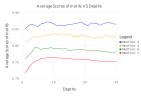

In [57]:
colors = ["Blue", "Orange", "Green", "Red","purple", "yellow", "violet","gold"]
legends = [string("Motif len: ", i) for i in motif_len_variation]
layers = Layer[]

chosen_colors = []
for i=1:length(scores)
    push!(chosen_colors, colors[i])
    push!(layers, layer(x=1:length(scores[i]), y=scores[i], Geom.line, Theme(default_color=parse(Gadfly.Colorant, colors[i])))[1])
end
Gadfly.plot(layers,
    Guide.xlabel("Generation"),
    Guide.ylabel("Average Fitness"),
    Guide.title("Genetic Algorithm: Progression of fitness"),
    Guide.manual_color_key("Legend", legends, chosen_colors))

## Hill Climbing

In [15]:
using Gadfly
using Distributions

In [16]:
motif_characters = ["A","C","T","G"]
function generate_random_motif(motif_length)
    motif=sample( motif_characters , motif_length; replace=true, ordered=false)
    return join(motif)
end

function get_all_substrings(string, l)
    substrings = []
    for start in 1:length(string)-l+1
        push!(substrings, string[start:start+l-1])
    end
    return substrings
end

function calculate_hamming_distance(string, motif)
    error = 0
    for i in 1:length(motif)
        if string[i] != motif[i]
            error += 1
        end
    end
    return error
end

function calculate_minimum_hamming_distance(motif, string)
    substrings=get_all_substrings(string, length(motif))
    return minimum([calculate_hamming_distance(str, motif) for str in  substrings])
end

function fitness(input_strings, motif)
    errors = 0
    for string in input_strings
        errors += calculate_minimum_hamming_distance(motif, string)
    end
    return errors
end

function get_all_neighbour_motifs(motif)
    neighbours=[]
    for i in 1:length(motif)
        for c in motif_characters
            if string(motif[i]) != c
                push!(neighbours,motif[1:i-1]*c*motif[i+1:length(motif)])
            end
        end
    end
    return neighbours
end

get_all_neighbour_motifs (generic function with 1 method)

In [17]:
function hill_climbing( input_strings, motif_length, maximum_restarts, depth, scores )
    total_score=motif_length*length(input_strings)
    
    answers = Set()
    seen = Set()
    for i in 1:maximum_restarts
        curr_motif = generate_random_motif(motif_length)
        curr_score = fitness(input_strings,curr_motif)
        temp=Float64[(total_score-curr_score)/total_score]
        for j in 1:depth
            if curr_motif in seen
                break
            end
            best_score=length(input_strings)*motif_length+1
            best_motif=""
            neighbours = get_all_neighbour_motifs(curr_motif)
            push!(seen,curr_motif)
            for n in neighbours
                score=fitness(input_strings,n)
                if score<best_score
                    best_score=score
                    best_motif=n
                end
            end
            
            push!(temp,(total_score-best_score)/total_score)
            if best_score==0
                push!(answers,best_motif)
                break
            end
            
            # Return current node since no better neighbors exist
            if best_score>curr_score
                break
            end
            curr_motif=best_motif
            curr_score=best_score
        end
        #println(temp)
        push!(scores, temp)
    end
    return collect(answers)
end

hill_climbing (generic function with 1 method)

In [18]:
no_of_motifs=10
no_of_strings=3
string_length=400
motif_length=30
generated_motifs, input_strings=create_artificial_sequence(no_of_strings, string_length, no_of_motifs, motif_length,107)

maximum_restarts=50
scores=[]
hill_climbing( input_strings, motif_length, maximum_restarts, motif_length, scores )

2-element Array{Any,1}:
 "ATGTGCATCAATTTTAGTCTTAGTTCCATT"
 "ATACCCCGCTCATGTAGTGATCTGTTCATG"

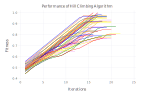

In [30]:
colors = ["Blue", "Orange", "Green", "Red","purple", "yellow", "violet","gold"]
layers = Layer[]
for i=1:length(scores)
   push!(layers, layer(x=1:length(scores[i]), y=scores[i], Geom.line, Theme(default_color=parse(Gadfly.Colorant,sample(colors))))[1])
end
pl=plot(layers,
    Guide.xlabel("Iterations"),
    Guide.ylabel("Fitness"),
    Guide.title("Performance of Hill Climbing Algorithm"))

In [31]:
#import Pkg
#import Pkg; 
#Pkg.add("Cairo")
#import Cairo
draw(PNG("hill_climbing_performance.png", 5inch, 5inch), pl)

## Histogram of fitness values

In [24]:
arr=[1,2,3,4,5,6,7,8,9,3,4,4,5,6,7,5,3,2,3,5,5,6,7,0,6,5,4,3,3]
plot(x=scores, 
    Geom.histogram(), 
    Theme( panel_fill=parse(Gadfly.Colorant, "White"),
           panel_stroke=parse(Gadfly.Colorant, "Blue"),
           background_color=parse(Gadfly.Colorant, "Orange")
        ), 
    Guide.ylabel("Frequency"),
    Guide.xlabel("Fitness")
    )

Plot(...)

## No. of iteration vs Accuracy

In [32]:
no_of_motifs=10
no_of_strings=3
string_length=200
restarts=[]
found_percent1=[]

start,gap,last=4,3,40

motif_length=5
generated_motifs, input_strings=create_artificial_sequence(no_of_strings, string_length, no_of_motifs, motif_length,107)
for max_restarts in start:gap:last
    total_motifs=0
    for i in 1:5
        detected_motifs=hill_climbing( input_strings, motif_length, max_restarts, motif_length, [])
        total_motifs+=length(detected_motifs)
    end
    total_motifs=total_motifs/5
    push!(restarts,max_restarts)
    push!(found_percent1,total_motifs*100/no_of_motifs)
end

motif_length=10
found_percent2=[]

generated_motifs, input_strings=create_artificial_sequence(no_of_strings, string_length, no_of_motifs, motif_length,31)
for max_restarts in start:gap:last
    total_motifs=0
    for i in 1:5
        detected_motifs=hill_climbing( input_strings, motif_length, max_restarts, motif_length, [])
        total_motifs+=length(detected_motifs)
    end
    total_motifs=total_motifs/5
    push!(found_percent2,total_motifs*100/no_of_motifs)
end


motif_length=15
found_percent3=[]
generated_motifs, input_strings=create_artificial_sequence(no_of_strings, string_length, no_of_motifs, motif_length,117)
for max_restarts in start:gap:last
    total_motifs=0
    for i in 1:5
        detected_motifs=hill_climbing( input_strings, motif_length, max_restarts, motif_length, [])
        total_motifs+=length(detected_motifs)
    end
    total_motifs=total_motifs/5
    push!(found_percent3,total_motifs*100/no_of_motifs)
end

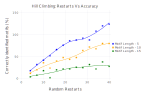

In [70]:
pl=plot(layer(x=restarts, y=found_percent1, Geom.smooth, Geom.point, Theme(default_color=parse(Gadfly.Colorant, "Blue"))),
     layer(x=restarts, y=found_percent2, Geom.smooth, Geom.point, Theme(default_color=parse(Gadfly.Colorant, "orange"))),
     layer(x=restarts, y=found_percent3, Geom.smooth, Geom.point, Theme(default_color=parse(Gadfly.Colorant, "Green"))),
    Guide.xlabel("Random Restarts"),
    Guide.ylabel("Correctly identified motifs (%)"),    
    Guide.title("Hill Climbing: Restarts Vs Accuracy"),    
    Guide.manual_color_key("", ["Motif Length - 5", "Motif Length - 10", "Motif Length - 15"],
                               ["Blue",             "Orange",            "Green"])
    )
#draw(PNG("hill_climbing_accuracy graph.png", 5inch, 5inch), pl)

In [124]:
no_of_motifs=4
no_of_strings=3
string_length=130
lengths=[]
time1,time2,time3=[],[],[]
for motif_length in 8:4:24
    generated_motifs, input_strings=create_artificial_sequence(no_of_strings, string_length, no_of_motifs, motif_length,117)
    
    t1=@elapsed branch_and_bound(input_strings,0,motif_length)

    t2=0
    for i in 1:5
        max_restarts=100
        t=@elapsed hill_climbing( input_strings, motif_length, max_restarts, motif_length, [])
        t2+=t
    end
    t2=t2/5.0
    
    depth=100
    pop_size=30
    t3=0
    for i in 1:5
        t = @elapsed genetic_algorithm(input_strings, pop_size, motif_length, [], ["A", "C", "G", "T"], 0, depth)
        t3+=t
    end
    t3=t3/5.0
    push!(lengths,motif_length)
    push!(time1,t1)
    push!(time2,t2)
    push!(time3,t3)
end

In [123]:
#Python code to generate graph
import numpy as np
import matplotlib.pyplot as plt

#The data
# womenMeans = (25, 32, 34, 20, 25)
# menMeans = (20, 35, 30, 35, 27)
# menMeans1 = (10, 30, 20, 35, 27)

indices =[9, 12, 15, 18]
one =[0.490318372, 0.24998653, 0.408196456, 2.147605466]
two=[1.9861179843999999, 2.4712425764, 3.6718308284, 6.9965780752]
three = [2.1695839552000002, 4.6306913548, 5.5856950552, 7.8982236096000005]
#Calculate optimal width
width = np.min(np.diff(indices))/len(indices)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width,one,width,color='b',label='-Ymin')
ax.bar(indices,two,width,color='r',label='Ymax')
ax.bar(indices+width,three,width,color='g',label='Ymax')

# ax.bar(indices,menMeans1,width,color='g',label='Ymax')

ax.set_xlabel('Motif Length')
ax.set_ylabel('Runtime in Seconds')
ax.set_title('Time to find the first motif')
ax.legend(['Branch and Bound','Hill Climbing','Genetic'])


plt.show()

Any[9, 12, 15, 18]
Any[0.490318372, 0.24998653, 0.408196456, 2.147605466]
Any[1.9861179843999999, 2.4712425764, 3.6718308284, 6.9965780752]
Any[2.1695839552000002, 4.6306913548, 5.5856950552, 7.8982236096000005]
